# This project has been done in two phases:
1. Explantaory Data Anaysis (EDA) to know more about the data
2. Topic modeling with LDA algorithm making use of the Gensim library.



### Libraries used 

In [78]:
#General libraries
import re, warnings
import pickle
import pandas as pd
import numpy as np
from random import randint
from operator import itemgetter
from string import digits
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Text Processing
import contractions
import nltk
from nltk.util import ngrams

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import spacy
en = spacy.load('en_core_web_sm')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

#Gensim
import gensim
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

stopwords_spacy = set(en.Defaults.stop_words)
stopwords_nltk = set(nltk.corpus.stopwords.words('english'))
inputFilepath = 'train_reviews.json'


# 1. Exploratory Data Analysis (EDA)
 
 In this section, some data analysis tasks have been done on the given dataset in order to get more familiar with dataset's nature. What have been done in this section are as follow:<br>
1. Investigating the columns
2. Checking for the duplicated data
3. Checking for the missing value
4. Data statistics based on rates(stars, dates)
5. General info per each filed (column)
6. Words representation

In [79]:
class EDA():
    
    def __init__(self,inputFilepath=inputFilepath):
        
        self.inputFilepath = inputFilepath
        self.data = self.redData()
    
    def redData(self):
        
        '''This functions read the data and convert the stars
        values to the numerical forms '''
        
        df = pd.read_json(self.inputFilepath)
        rateMap = {'star-rating star-rating-1 star-rating--medium':1,
       'star-rating star-rating-4 star-rating--medium':4,
       'star-rating star-rating-5 star-rating--medium':5,
       'star-rating star-rating-2 star-rating--medium':2,
       'star-rating star-rating-3 star-rating--medium':3}
        df=df.replace({"stars": rateMap})
        
        df['date'] = pd.to_datetime(df.date).dt.date
        df['date'] = pd.to_datetime(df.date, format= '%Y-%m-%d')
        df['year'] = pd.DatetimeIndex(df.date).year
        df['month'] = pd.DatetimeIndex(df.date).month
        return df
    
    def generalInfo(self):
        
        '''This functions gives general info on a given dataset'''
        
        duplicated = 0
        missingValue = 0
        columns = self.data.columns
        originalSamples = len(self.data)
        bool_series = self.data.duplicated(keep='first')
        df = self.data[~bool_series]
        duplicateRemovedSamples = len(df)
        diff = originalSamples - duplicateRemovedSamples
        if diff > 0:
            duplicated = 1
            
        s = df.isnull().sum().sum()
        if s > 0:
            missingValue = 1
        
        print(f'*) The data set consist of the {len(columns)} fileds as following:')
        print(columns)
        print(f'\n*) This dataset totally has {originalSamples} samples, in which {diff} of them are dupliucated. It means that there is {originalSamples - diff} unique samples.')
        print(f'\n*) There is no missing value in the dataset!')
        
        return
        
    def textualFiledsInfo(self):
        
        '''This function gives some info about the textual fileds
        in the data set (text, and title)'''
        
        title_tokens = self.data.title.apply(self.sentenceLen)
        title_sent = self.data.title.apply(self.numSentences)
        text_tokens = self.data.text.apply(self.sentenceLen)
        text_sent = self.data.text.apply(self.numSentences)
        print('Title:\n*****')
        print(f'The average number of sentence in Title is: {round(np.mean(title_sent))}')
        print(f'The average number of tokens in Title is: {round(np.mean(title_tokens))}')
        print('Text:\n*****')
        print(f'The average number of sentence in Text is: {round(np.mean(text_sent))}')
        print(f'The average number of tokens in Text is: {round(np.mean(text_tokens))}')
        
    
    def dataDistribution(self):
    
        '''This function represents the 
        distribution of the comments over ratings(stars).'''
        
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)        
        stars_count = self.data.stars.value_counts()
        ax = stars_count.plot(kind='pie',autopct='%1.1f%%')
        ax.set_title('Data distribution over ratings.')
        plt.subplot(1,2,2)
        years_count = self.data.year.value_counts()
        ax = years_count.plot(kind='pie')
        ax.set_title('Data distribution over year.')
        return
    
    def wordStatistics(self):
        
        '''This function computes the percentage of the 
        stopswords appeared in the comments in dataset. '''
        
        docs = self.data['title']+'. '+self.data['text']
        allTokens = []
        Lenghts = []
        stopWordCount = 0
        for doc in docs.values.tolist():
            tokens = nltk.word_tokenize(doc)
            Lenghts.append(len(tokens))
            for t in tokens:
                if t in stopwords_spacy:
                    stopWordCount +=1
            allTokens.extend(tokens)
        plt.figure(figsize=(16,7), dpi=160)
        plt.hist(Lenghts, bins = 1000, color='navy')
        plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
        plt.tick_params(size=16)
        plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
        plt.show()
        self.generateWordcloud(' '.join(allTokens), 'Word cloud of all the words inside the comments', stopwords=None)
        print(f' {100 * stopWordCount / len(allTokens):.2f} percentage of the tokens are stopwords!')
        
    @staticmethod
    def sentenceLen(text):
    
        '''This function uses to find the,
        lenght of each sentence (token wise)!'''

        tokens = nltk.word_tokenize(text)
        return len(tokens)
    
    @staticmethod
    def numSentences(doc):

        '''This function uses to find the number
        of sentences in a given document'''
        sentences = nltk.tokenize.sent_tokenize(doc)
        return len(sentences)
    
    @staticmethod
    def generateWordcloud(wordsListStr, title, stopwords=None):
    
        '''This the a function to create the
        word cloud'''

        cloud = WordCloud(width=400,
                          height=330,
                          max_words=200,
                          colormap='tab20c',
                          random_state=123,
                          stopwords=stopwords,
                          collocations=True).generate(wordsListStr)
        plt.figure(figsize=(10,8))
        plt.imshow(cloud)
        plt.axis('off')
        plt.title(title, fontsize=13)
        plt.show()

#### 1.1 General Info

In [80]:
eda = EDA()
eda.generalInfo()

*) The data set consist of the 7 fileds as following:
Index(['date', 'title', 'text', 'url', 'stars', 'year', 'month'], dtype='object')

*) This dataset totally has 2021 samples, in which 380 of them are dupliucated. It means that there is 1641 unique samples.

*) There is no missing value in the dataset!


In [81]:
eda.data.head()

,date,title,text,url,stars,year,month
0,2015-10-10,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,1,2015,10
1,2015-09-22,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,1,2015,9
2,2015-03-13,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,1,2015,3
3,2015-01-13,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,4,2015,1
4,2011-05-28,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,4,2011,5


#### 1.2 Information about the textual fileds <ber>
    According to the numbers below, it seems that there is no need to process the titles and texts separately. They can be concatenated together.

In [82]:
eda.textualFiledsInfo()

Title:
*****
The average number of sentence in Title is: 1
The average number of tokens in Title is: 6
Text:
*****
The average number of sentence in Text is: 4
The average number of tokens in Text is: 68


#### 1.3 Data distribution according to the ratings (stars)  <br>
    As it can be seen from the chart below, the number of comments with low rate (1) is much more than the other types. It can imply that the most of the topics must be about the customers' complaints.

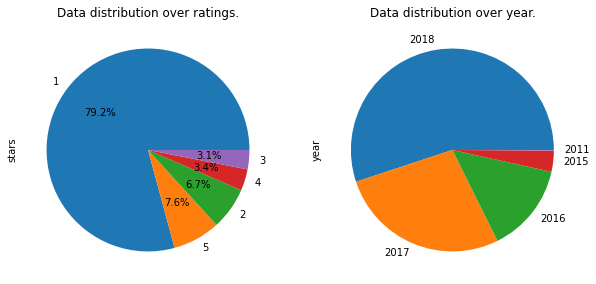

In [83]:
eda.dataDistribution()

#### 1.4 Words representation <br> 
According to the statistics below, almost half of the words used in the comments are stopwords. This amount of stopwords can confuse the model. That's why they can be removed in the model training phase. 

Looking at the word cloud presented below, it can be understood that most of the complaint must be about the **time, customer services, tickets refund, delays, etc.** 

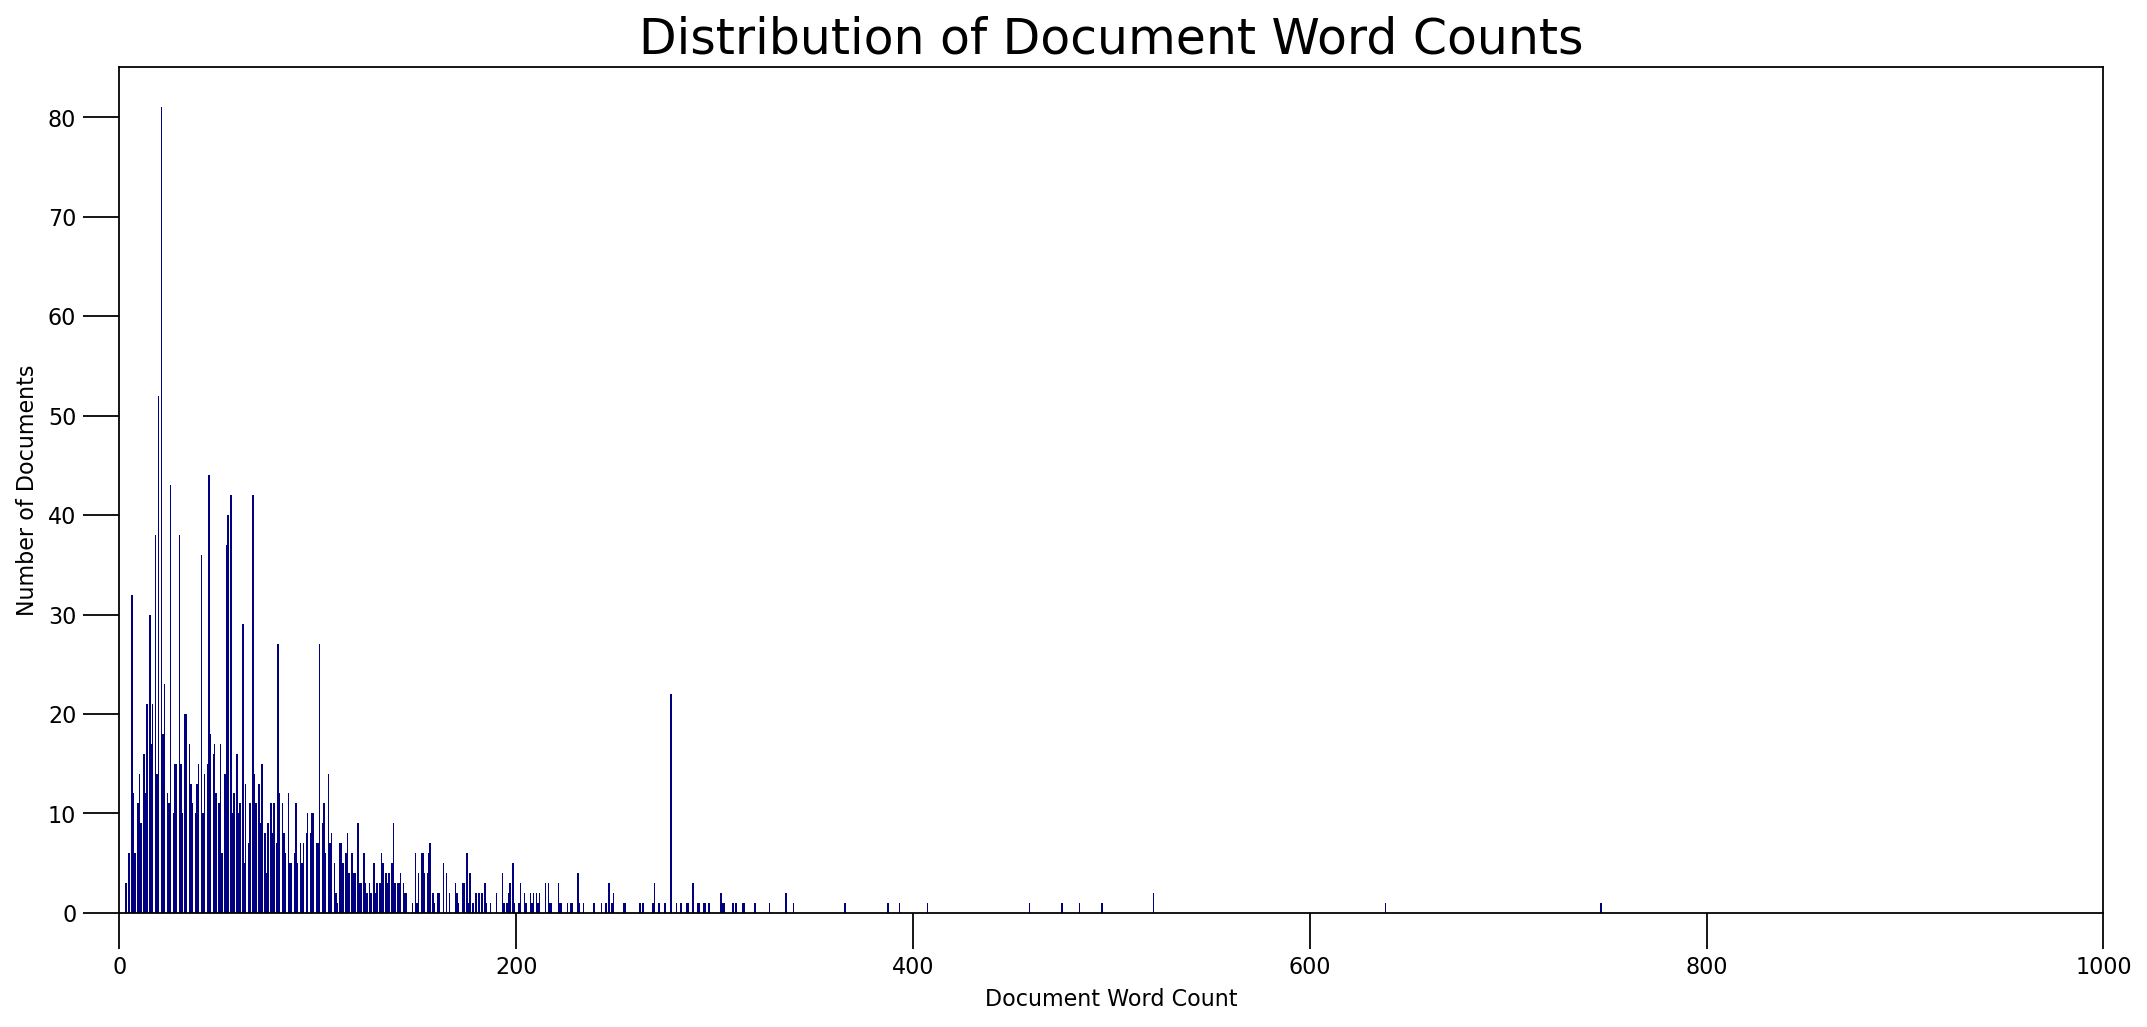

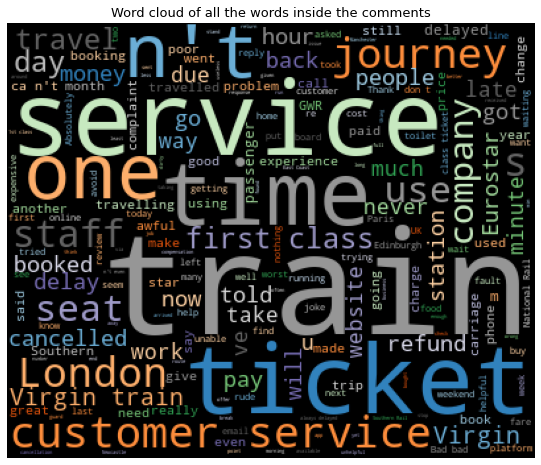

 42.63 percentage of the tokens are stopwords!


In [84]:
eda.wordStatistics()

## Summary   <br> 
According to the overal information obtained from the dataset it can be seen that: <br>
1. Dataset consists of **5 fileds including: date, title, text, url, stars**
2. Although there are **2021 data objects** in the dataset but **380** of them are duplicated- they are now removed.
3. Considering the low average number of sentences in the **title and text** fileds, **they can be combined**  to have a single textual field.
4. Dataset **has no missing value** which is good.
5. Rating (stars) are ranged from (1-5) for each review comment- the textual values can be converted to the numerical ones.
6. Looking at the **primitive word clouds**, it can be seen that the most common key words are somehow relevant to the train schedules.
7. Distribution of the data over ratings, reveals that most of the comments are about the **weaknesses** of the new scheduling system. 
8.  42.63 percentage of the tokens are stopwords!
9. Majority of the comments are for 2018 which shows that the people were sensteive about the new train schedules and they are more affected.



# 2. Topic Model
In this phase, data are prepared for the processing by LDA whicjh is implemented in gensim. To process the data to be usable with LDA, the following tasks have been done:

0. Combining the text and title
1. Contraction correction
2. Removing the punctuations and digits
3. Tokenization
4. ngrams generation (for n=1,2,3)
5. Lemmatization
6. removing stopwords (stopwords from **spacy** is used for this purpose)
7. lower casing the text
8. sorting the comments according to the date


In [85]:
class topicModel():
    
    def __init__(self, inputFilepath = inputFilepath, stopwords = stopwords_spacy,  ngram = 1, num_topics=5):
       
        self.inputFilepath = inputFilepath
        self.stopwords = list(stopwords_spacy)
        self.ngram = ngram
        self.num_topics = num_topics
        self.data = self.readData()
        self.data['cleanText'] = self.data['text'].apply(self.transformText)
        self.data['ngText'] = self.data['cleanText'].apply(self.nGramPhrase)
        self.create_dictionary_corpus(self.data.ngText.values.tolist())
        self.model = None
        
    def readData(self):
        
        '''This function does the followings:
        1. Read the json file
        2. Convert the full dateTime to only date (yy-mm)
        3. Remove the duplicates
        4. Check for the missing values
        5. concatenate the title with text as text
        6. Seperate the year and month in different columns'''
        
        df = pd.read_json(self.inputFilepath)
        originalSamples = len(df)
        df['date'] = pd.to_datetime(df.date).dt.date
        df['date'] = pd.to_datetime(df.date, format= '%Y-%m-%d')
        df['year'] = pd.DatetimeIndex(df.date).year
        df['month'] = pd.DatetimeIndex(df.date).month
        bool_series = df.duplicated(keep='first')
        df = df[~bool_series]
        duplicateRemovedSamples = len(df)
        diff = originalSamples - duplicateRemovedSamples
        s = df.isnull().sum().sum()
        df['text'] = df['title'] + '. '+df['text'] 
        rateMap = {'star-rating star-rating-1 star-rating--medium':1,
       'star-rating star-rating-4 star-rating--medium':4,
       'star-rating star-rating-5 star-rating--medium':5,
       'star-rating star-rating-2 star-rating--medium':2,
       'star-rating star-rating-3 star-rating--medium':3}
        df=df.replace({"stars": rateMap})
        
        return df[['year','month','text','stars']]
         
       
    def transformText(self,text):
        
        '''Basic text preprocessing including:
        1. Lowercasing
        2. Fixing the contactions
        3. Removing the punctuations
        4. Removing the digits'''
        
        
        
        def fixContractions(text):
            return contractions.fix(text)

        def removePunctuation(text):
            text = re.sub(r'\s{2,}', ' ', text)
            return re.sub(r'[^\w\s]', '', text)
        
        def removeDigits(text):
            table = str.maketrans('', '', digits)
            newstring = text.translate(table)
            return newstring
        
        text = fixContractions(text.lower())
        text = removePunctuation(text)
        return removeDigits(text)
    
    def tokenize(self,text):
        return nltk.word_tokenize(text)
    
    def nGramPhrase(self,text):
        
        '''This function generates onegram tokens to ngrams.
        It also removes the stop words and convert the resulted tokens
        in to their lemmas.
        '''
        tokens = nltk.word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stopwords]
        ng = tokens[:]
        if self.ngram > 1:
            for i in range(2,self.ngram+1):
                k = ngrams(tokens,i)
                for a in list(k):
                    ng.append('_'.join(list(a)))
        
        ng = [lemmatizer.lemmatize(t) for t in ng]
        return ng
    
    def create_dictionary_corpus(self,listOfTokenizedsentences):
        
        '''This g=function creates a dictionary and corpus needed
        for gensim to train the model.'''
        
        id2word = corpora.Dictionary(listOfTokenizedsentences)
        corpus = [id2word.doc2bow(text) for text in listOfTokenizedsentences]
        self.id2word = id2word
        
#         tfidf = models.TfidfModel(corpus)
#         corpus_tfidf = tfidf[corpus]
#         self.corpus = corpus_tfidf

        self.corpus = corpus
        pickle.dump(corpus, open('corpus.pkl', 'wb'))
        id2word.save('id2word.gensim')
        
    def buildModel(self):
        
        '''This function is res[ponsible to create and train
        a lda model from gensim. '''
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=self.corpus,
                                                       id2word=self.id2word,
                                                       num_topics= self.num_topics, 
                                                       random_state=100,
                                                       update_every=1,
                                                       chunksize=10,
                                                       passes=10,
                                                       alpha='auto',
                                                       iterations=100,
                                                       per_word_topics=False)
        self.model = lda_model
        lda_model.save('model5.gensim')

        return lda_model
    
    
    def  printTopics(self):
        
        '''This function prints the topics'''
        
        topics = self.model.print_topics(num_words=10) # Indicate 10 most relevant words for each topic
        for topic in topics:
            print(topic)
     
    def modelEvaluation(self):
        
        ''' This functions evaluate the quality of the model
        according to it coherence score.'''
        
        cml = CoherenceModel(model=self.model,texts=self.data.ngText.values.tolist(), dictionary= self.id2word, coherence='c_v')
        coherenceValue = cml.get_coherence()
        print(f'\n Coherence score of the model is: {coherenceValue}')
        
    def modelVisualization(self):
        
        '''Thsi fucntion uses for the topics visualization'''
        
        lda_display = gensimvis.prepare(self.model,self.corpus,self.id2word, sort_topics=False)
        pyLDAvis.display(lda_display)  
        
    def docTopics(self,doc):
        
        '''This function applies the trained model on 
        agive doc to find the dominant topic.'''
                
        doc = self.nGramPhrase(self.transformText(doc))
        doc_bow = self.id2word.doc2bow(doc)
        topics = self.model.get_document_topics(doc_bow)
        return topics
   
    @staticmethod
    def dominantTopic(topicList):
        
        '''This functions return the dominant
            topic among the list of topics for each document.'''

        res = max(topicList, key=itemgetter(1))[0]
        return res 
    
   
    def dominantTopicKeywords(self,topicList):
        
        '''This functions return the dominant
            topic among the list of topics for each document.'''

        res = max(topicList, key=itemgetter(1))[0]
        words = []
        for t in self.model.show_topic(res):
            words.append(t[0])
        return ','.join(words) 
    
    @staticmethod
    def dominantTopicPercentage(topicList):
        
        '''This functions return the dominant
            topic percentage among the list of topics for each document.'''

        res = max(topicList, key=itemgetter(1))[1]
        return res
    
    def dataDistribution(self):
    
        '''This function represents the 
        distribution of the topics over ratings(stars).'''
        
        plt.figure(figsize=(4,4))
        stars_count = self.data.dominantTopic.value_counts()
        ax = stars_count.plot(kind='pie',autopct='%1.1f%%')
        ax.set_title('Topic distribution over dataset.')

        return
    
    def topicYearDistribution(self):
    
        '''This function represents the 
        distribution of the topics over years.'''
        
        years = self.data['year'].unique()
        years = np.sort(years)
        df = self.data[['year','dominantTopic']]
        for y in years:
            df1 = df[df['year'] == y]
            plt.figure(figsize = (4,4))
            topic_count = df1.dominantTopic.value_counts()
            ax = topic_count.plot(kind='pie',autopct='%1.1f%%')
            ax.set_title('Topic distribution over dataset in.'+str(y))
            plt.show()

        return
        

### 2.1 Read data and do preprocessing
In this step, after reasding the data, preprocessing tasks apply on it including the ones mentioned above.

In [86]:
obj = topicModel( ngram = 3, num_topics=5)
obj.data.head()

,year,month,text,stars,cleanText,ngText
0,2015,10,Bad customer service. Staff are very impolite ...,1,bad customer service staff are very impolite a...,"[bad, customer, service, staff, impolite, rude..."
1,2015,9,Pretty awful service. I phoned National rail t...,1,pretty awful service i phoned national rail to...,"[pretty, awful, service, phoned, national, rai..."
2,2015,3,Awful staff. I travel from Brokenhast to south...,1,awful staff i travel from brokenhast to southa...,"[awful, staff, travel, brokenhast, southampton..."
3,2015,1,Very good. Saved about £50 on a single trip us...,4,very good saved about on a single trip using ...,"[good, saved, single, trip, nationalrail, pick..."
4,2011,5,Check it out.. I always use the national rail ...,4,check it out i always use the national rail en...,"[check, use, national, rail, enquiry, site, pl..."


### 2.2 Build a Model
In this stage, an LDA topic model is going to be created making use of the gensim. The needed dictionar and corpus for training are already created in the previous step. By the way, due to the time limitation, I haven't played with hyperparameters and used some rnadom values.

In [87]:
lda_model = obj.buildModel()

### 2.3 Model Evaluation
To evaluate the quality of the model trained, coherence score is leveraged here. The higher value for the coherence, the qood model trained!

The performance of the model using onegram or bigram is around 12 percent less than using trigrams. 

In [88]:
obj.modelEvaluation()


 Coherence score of the model is: 0.48800721963598725


### 2.4 Print the Topics Distributed over Dataset

In [89]:
obj.printTopics()

(0, '0.040*"train" + 0.008*"delayed" + 0.007*"cancelled" + 0.006*"late" + 0.006*"journey" + 0.006*"hour" + 0.004*"start" + 0.004*"new" + 0.003*"passenger" + 0.003*"minute"')
(1, '0.010*"ticket" + 0.010*"service" + 0.009*"train" + 0.009*"time" + 0.007*"london" + 0.007*"seat" + 0.006*"day" + 0.005*"travel" + 0.005*"company" + 0.004*"return"')
(2, '0.011*"ticket" + 0.004*"purchased" + 0.004*"awful" + 0.004*"email" + 0.003*"asked" + 0.003*"buy" + 0.003*"going" + 0.003*"pay" + 0.003*"said" + 0.003*"reply"')
(3, '0.010*"class" + 0.004*"star" + 0.003*"conductor" + 0.003*"dirty" + 0.002*"standard" + 0.002*"travelled" + 0.002*"review" + 0.002*"single" + 0.002*"transport" + 0.002*"away"')
(4, '0.027*"service" + 0.013*"customer" + 0.008*"customer_service" + 0.007*"staff" + 0.007*"delay" + 0.006*"use" + 0.006*"station" + 0.005*"terrible" + 0.004*"dreadful" + 0.004*"refund"')


*According to the key words per ecach topic, one can say that the toics are:*

In [90]:
topicMap = {0:'Cancellation',1:'Ticket for london',2:'online service',3:'low quality trains',4:'customer Service'}

### 2.5 Apply the Model on Dataset

In [91]:
obj.data['Topics'] = obj.data.text.apply(obj.docTopics)
obj.data.head()

,year,month,text,stars,cleanText,ngText,Topics
0,2015,10,Bad customer service. Staff are very impolite ...,1,bad customer service staff are very impolite a...,"[bad, customer, service, staff, impolite, rude...","[(0, 0.09011617), (1, 0.18877517), (2, 0.02475..."
1,2015,9,Pretty awful service. I phoned National rail t...,1,pretty awful service i phoned national rail to...,"[pretty, awful, service, phoned, national, rai...","[(0, 0.3058095), (1, 0.15595317), (2, 0.123974..."
2,2015,3,Awful staff. I travel from Brokenhast to south...,1,awful staff i travel from brokenhast to southa...,"[awful, staff, travel, brokenhast, southampton...","[(0, 0.046313345), (1, 0.17071511), (2, 0.6276..."
3,2015,1,Very good. Saved about £50 on a single trip us...,4,very good saved about on a single trip using ...,"[good, saved, single, trip, nationalrail, pick...","[(0, 0.13973776), (1, 0.13951574), (2, 0.10102..."
4,2011,5,Check it out.. I always use the national rail ...,4,check it out i always use the national rail en...,"[check, use, national, rail, enquiry, site, pl...","[(0, 0.090808034), (1, 0.33712536), (2, 0.0327..."


### 2.6 Find the Dominant Topic for each Sample
In this step the percentage of the dominant comment and its corresponding keywords will also be extracted.

In [92]:
obj.data['dominantTopic'] = obj.data.Topics.apply(obj.dominantTopic)
obj.data['dominantTopicPercentage'] = obj.data.Topics.apply(obj.dominantTopicPercentage)
obj.data['dominantTopicKeywords'] = obj.data.Topics.apply(obj.dominantTopicKeywords)

obj.data.head()


,year,month,text,stars,cleanText,ngText,Topics,dominantTopic,dominantTopicPercentage,dominantTopicKeywords
0,2015,10,Bad customer service. Staff are very impolite ...,1,bad customer service staff are very impolite a...,"[bad, customer, service, staff, impolite, rude...","[(0, 0.09011617), (1, 0.18877517), (2, 0.02475...",4,0.690588,"service,customer,customer_service,staff,delay,..."
1,2015,9,Pretty awful service. I phoned National rail t...,1,pretty awful service i phoned national rail to...,"[pretty, awful, service, phoned, national, rai...","[(0, 0.3058095), (1, 0.15595317), (2, 0.123974...",4,0.412352,"service,customer,customer_service,staff,delay,..."
2,2015,3,Awful staff. I travel from Brokenhast to south...,1,awful staff i travel from brokenhast to southa...,"[awful, staff, travel, brokenhast, southampton...","[(0, 0.046313345), (1, 0.17071511), (2, 0.6276...",2,0.627621,"ticket,purchased,awful,email,asked,buy,going,p..."
3,2015,1,Very good. Saved about £50 on a single trip us...,4,very good saved about on a single trip using ...,"[good, saved, single, trip, nationalrail, pick...","[(0, 0.13973776), (1, 0.13951574), (2, 0.10102...",4,0.516399,"service,customer,customer_service,staff,delay,..."
4,2011,5,Check it out.. I always use the national rail ...,4,check it out i always use the national rail en...,"[check, use, national, rail, enquiry, site, pl...","[(0, 0.090808034), (1, 0.33712536), (2, 0.0327...",4,0.532355,"service,customer,customer_service,staff,delay,..."


### 2.7 Model Visualization

In [96]:
# obj.modelVisualization()
lda_display = gensimvis.prepare(obj.model,obj.corpus,obj.id2word, sort_topics=False)
pyLDAvis.display(lda_display) 

C:\Users\aakkasi\Anaconda3\envs\okra\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### 2.8 Topic Distribution

#### 2.8.1 Topic Distibution Over Dataset

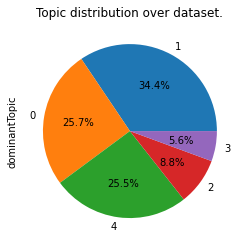

In [94]:
obj.dataDistribution()

#### 2.8.2 Topic Distibution Over Years 

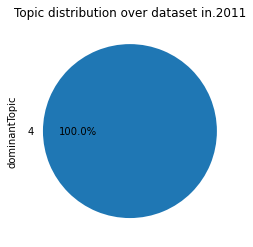

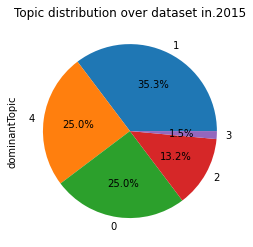

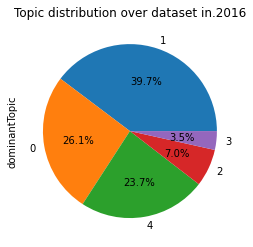

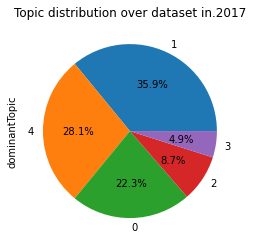

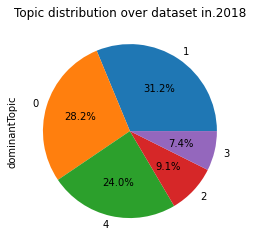

In [95]:
obj.topicYearDistribution()


*As It can be seen from the charts, the topics are changed year by year.* 

## Final Note
-------------
In this experiment, I didn't do hyperparametr tuning which I am sure that by good values of them the model performance can be improved more. In addition, according to the recent findings, applying the transformer based approaches such as TopicBERT showed very promissing results comparing to the traditional approaches. Making use of such methods can be considered as alternative for current LDA method. 